<a href="https://colab.research.google.com/github/ellagattis/hpc/blob/main/assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4



> Ella Buehner Gattis SN 17015416



At last run before submission the total runtime of this notebook on Colab was just over 2 minutes (something like 2:10)

Consider a square plate with sides $[-1, 1]\times [-1, 1]$. At time $t=0$ we are heating the plate up such that $u=5$ on one side and $u=0$ on the other sides. The temperature evolves according to $u_t=\Delta u$. At what time $t^*$ does the plate reach $u=1$ at the center of the plate? 
* Implement a finite difference scheme and try with explicit and implicit time-stepping. 
* By increasing the number of discretisation points demonstrate how many correct digits you can achieve. 
* Show convincing benchmark experiments. 
* Think about your implementation (you need not use GPU programming if you don’t want to) and how you want to present your results. An efficient implementation is worth 50%. The other 50% are focused on good and convincing presentation. 

Hint: To 12 digits the wanted solution is $t^*=0.424011387033.$

In [ ]:
#necessary imports
import math
import time
import numba
import numpy as np
from matplotlib import pyplot as plt
from scipy.sparse.linalg import spsolve
from mpl_toolkits.mplot3d import axes3d
from scipy.sparse import coo_matrix, identity

Text(0.5, 1.0, 'visualising the plate extent')

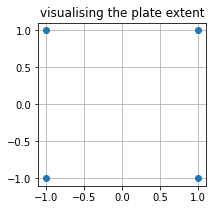

In [ ]:
edgesx = [-1, 1, -1, 1]
edgesy = [-1, 1, 1, -1]
plt.figure(figsize=(3,3))
plt.plot(edgesx, edgesy, 'o')
plt.grid(True)
plt.title('visualising the plate extent')

## Explicit time stepping

first I have copied the CPU function  to evaluate the Laplacian `discretise_poisson` that generates the left-hand side matrix from the lecture notes. 

I have changed $h$ to $h=\frac{2}{N-1}$ because the grid now runs from -1 to 1 instead of 0 to 1. 

I have also set the boundary conditions so that $u=5$ on the left edge of the grid, ie where $i=0$.

For the explicit time stepping I will use the forward Euler method, which gives $U_{n+1} = U_n + \Delta tf(U_n, t_n).$


\begin{split}
\begin{align}
U_{n+1} &= (1+\alpha\Delta t)U_n\nonumber\\
        &= (1+\alpha\Delta t)^nU_0.
\end{align}
\end{split}


In [ ]:
# copied from the notes, modified for our problem
def discretise_poisson(N):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    
    nelements = 5 * N**2 - 16 * N + 16

    h = 2/(N-1)
    
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    f = np.empty(N * N, dtype=np.float64)
    
    count = 0
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                f[j * N + i] = 0
                count += 1
                
            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i
                                
                data[count] = -4 / (h**2)
                data[count + 1 : count + 5] =  1/(h**2)
                f[j * N + i] = 1
                
                count += 5
                                                
    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f

using 

$\textbf{U}^{n+1} = (\textbf{I}+\Delta t\textbf{A})\textbf{U}^{n}$

where $\textbf{I}$ is the identity matrix and $\textbf{A}$ is the matrix generated by our `discretise_poisson` function.

I have set N as always being odd so that there is always a single value at the center of the grid to evaluate. I set the boundary condition $u=5$ at the corner of the grid within the `forward_euler` function so that the boundary condition is set at every iteration.

In [ ]:
def forward_euler(u, dt):
  """Explicit time stepping for Laplace operator using forward Euler"""
  u = u.reshape((N*N))
  u_n1 = (I+dt*A)@u
  u_n1 = u_n1.reshape((N, N))
  u_n1[:,0] = 5
  return u_n1

In [ ]:
t_12 = 0.424011387033 #correct time to 12 digits
# some example parameters to start with
N = 25
dt = 0.0001

In [ ]:
A, _ = discretise_poisson(N)
I = identity(N*N)
x = np.zeros((N, N))
x[:,0] = 5

time taken: 0.4239999999999696.
correct time to 12 digits: 0.424011387033.


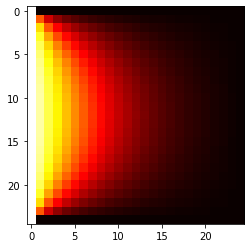

In [ ]:
t_steps = 0
while x[N//2, N//2] < 1:
  t_steps += dt
  x = forward_euler(x, dt)

print(f"time taken: {t_steps}.")
print(f"correct time to 12 digits: {t_12}.")
plt.imshow(x, cmap='hot')

Using values of N=25 and dt = 0.0001 with my function returns a value of t that is correct to 2 digits (3 if you round). While the relative and absolute error are both very small, we can see that this is not necessarily a very precise answer. I would guess that the number of correct digits is given by the power of 10 of dt, ie here dt=10^(-3) and the answer is correct to 3 digits. However because forward Euler is not uncodnitionally stable this will not always hold.

In [ ]:
rel_error = (t_12 - t_steps) / (t_12)
print(f"Relative errorr: {rel_error}.")

Relative errorr: 2.6855488740681728e-05.


In [ ]:
absolute_error = abs(t_12 - t_steps)
np.log10(1/absolute_error)
print(absolute_error)
print(np.log10(1/absolute_error))

1.1387033030385574e-05
4.943589419589532


Here I am implementing a for loop over different values of N and dt to measure how t varies as a function of the two. The smallest dt value I have used is dt = 10^-4 because when I have tried to run it with any smaller values, the code takes a very long time to execute.

In [ ]:
Nlist = []
dtlist = []
extimelist = []
terrlist = []
for N in range(21, 201, 20):
  A, _ = discretise_poisson(N)
  I = identity(N*N)
  #print("\nN = ", N)

  #dt ranges from 10e-3 to 10e-1 in powers of ten
  powersten = [-1, -2, -3, -4]
  for i in powersten:
    execution_time = 0
    start = time.time()
    dt = 10**i

    dtlist.append(dt)
    Nlist.append(N)

    x = np.zeros((N, N))
    x[:,0] = 5
    t_steps = 0
    while x[N//2, N//2] < 1:
      t_steps += dt
      x = forward_euler(x, dt)

    execution_time = (time.time() - start)
    absolute_error = abs(t_12 - t_steps)

    extimelist.append(execution_time)
    terrlist.append(absolute_error)

    print("dt = ", dt)
    print(f"t = {t_steps}.")
    print("execution time ", execution_time, "s")

dt =  0.1
t = 0.9999999999999999.
execution time  0.008270025253295898 s
dt =  0.01
t = 0.09999999999999999.
execution time  0.009485244750976562 s
dt =  0.001
t = 0.4240000000000003.
execution time  0.17528772354125977 s
dt =  0.0001
t = 0.4239999999999696.
execution time  1.7445850372314453 s
dt =  0.1
t = 2.0000000000000004.
execution time  0.009476184844970703 s
dt =  0.01
t = 0.20000000000000004.
execution time  0.009272336959838867 s
dt =  0.001
t = 0.04500000000000003.
execution time  0.02304363250732422 s
dt =  0.0001
t = 0.4239999999999696.
execution time  2.0543816089630127 s
dt =  0.1
t = 3.0000000000000013.
execution time  0.018431901931762695 s
dt =  0.01
t = 0.3000000000000001.
execution time  0.018484115600585938 s
dt =  0.001
t = 0.03200000000000002.
execution time  0.020430326461791992 s
dt =  0.0001
t = 0.4239999999999696.
execution time  2.5776195526123047 s
dt =  0.1
t = 4.000000000000002.
execution time  0.03366971015930176 s
dt =  0.01
t = 0.4000000000000002.
exec

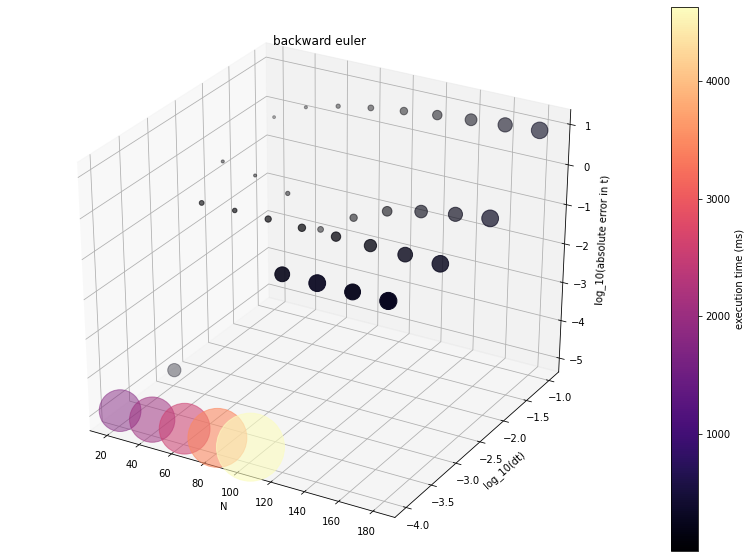

In [ ]:
#now plot results
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('backward euler')

extimelist[:] = [l * 1000 for l in extimelist]
#terrlist[:] = [1/l  for l in terrlist]
plot = ax.scatter(Nlist, np.log10(dtlist), np.log10(terrlist), c = extimelist, cmap = 'magma', s=(extimelist))

ax.set_xlabel('N')
ax.set_ylabel('log_10(dt)')
ax.set_zlabel('log_10(absolute error in t)')

cbar = fig.colorbar(plot)
cbar.set_label('execution time (ms)')

Here we see the effect of the stability conditions for forward Euler. For a solution to decay, we require that $|\alpha\Delta t| < 2$, from which we gat for forward Euler to converge $\Delta t < \frac{2}{|\lambda_{max}(A)|}$ where $\lambda_{max}$ is the largest magnitude eigenvalue. Some more algebra leads to the condition $\frac{\Delta t}{dt^2} \lesssim \frac{1}{2}.$, ie $\Delta t \sim dt^2$ so the number of required time steps grows quadratically with the discretisation accuracy.

This means that for high N we require dt to be very small in order to get an accurate solution - we see in the graph that for higher N values the error becomes very large as dt is not small enough for the forward Euler method to be stable. In my graph I have represented the execution time (not the same as $t*$) using a colourbar as well as the point size. We see that for the stable regions, runtime increases as N grows and dt becomes smaller, which makes sense.

The forward Euler method is computationally not very expensive as all of the runtimes are fairly small, but the stability conditions means that it returns highly inaccurate values quite a lot of the time. We have to choose the time discretisation carefully depending on the space discretisation.



In [ ]:
#test- how many correct digits can I get within a reasonable time?
N = 25
dt = 1e-5
A, _ = discretise_poisson(N)
I = identity(N*N)
x = np.zeros((N, N))
x[:,0] = 5
t_steps = 0
while x[N//2, N//2] < 1:
  t_steps += dt
  x = forward_euler(x, dt)

print(f"time taken: {t_steps}.")
print(f"correct time to 12 digits: {t_12}.")

time taken: 0.4240300000002833.
correct time to 12 digits: 0.424011387033.


If I choose dt = 1e-5 I get a solution that is correct to 5 digits which follows my guess that the number of correct digits is equal to the negative power ten of dt. I tried this with smaller dt values but it took too long to run.

## Implicit time stepping

For the implicit time stepping I will use the backward Euler method, which gives  $U_{n+1} = U_{n} + \Delta tf(U_{n+1}, t_{n+1}).$

\begin{split}
\begin{align}
U_{n+1} &= (1-\alpha\Delta t)^{-1}U_n\nonumber\\
        &= (1-\alpha\Delta t)^{-n}U_0.
\end{align}
\end{split}

here I use `scipy.sparse.linalg.spsolve` to find 

$\textbf{U}^{n+1} = (\textbf{I}-\Delta t\textbf{A})^{-1}\textbf{U}^{n}$

where $\textbf{I}$ is the identity matrix and $\textbf{A}$ is the matrix generated by our `discretise_poisson` function.

In [ ]:
def backward_euler(u, dt):
  """Implicit time stepping for Laplace operator using backward Euler"""
  u = u.reshape((N*N))
  u_n1 = spsolve((I-dt*A), u)
  u_n1 = u_n1.reshape((N, N))
  u_n1[:,0] = 5
  return u_n1

In [ ]:
#reset parameters
t_steps = 0
N = 25
dt = 0.0001
x = np.zeros((N, N))
x[:,0] = 5
A, _ = discretise_poisson(N)
I = identity(N*N)
while x[N//2, N//2] < 1:
  t_steps += dt
  x = backward_euler(x, dt)
print(f"time taken: {t_steps}.")
print(f"correct time to 12 digits: {t_12}.")

time taken: 0.4240999999999696.
correct time to 12 digits: 0.424011387033.


In [ ]:
rel_error = (t_12 - t_steps) / (t_12)
abs_error = abs(t_12 - t_steps)
print(f"Relative errorr: {rel_error}.")
print(f"Absolute error: {abs_error}.")

Relative errorr: -0.00020898723402139866.
Absolute error: 8.861296696960341e-05.


Here the solution is correct to 4 digits - 5 if you round to 5sf, which is a much greater accuracy than for the same N and dt values using forward Euler. This may be because of the unconditional stability of backward Euler. This does not fit with my guess that the digits of accuracy is given by the power of 10 of dt. However, the runtime is much slower, as this is much more computationally expensive. This is because for every step we are having to solve a system of linear equations (here I have done this with `spsolve`) rather than a much cheaper matrix multiplication as in forward Euler.

Again I am implementing a for loop to go over different values of N and dt. However here I have gone in steps of 40 rather than 20 because backward Euler runs much more slowly. Originally I decided I should still have the same range (max and min) N values and the same dt values for fair comparison, but the notebook runtime is too long if my step size remains the same, so I am taking fewer points for N, and going to a maximum value of 91.

In [ ]:
Nlist = []
dtlist = []
extimelist = []
terrlist = []
for N in range(11, 93, 40):
  A, _ = discretise_poisson(N)
  I = identity(N*N)
  print("\nN = ", N)
  #dt ranges from 10e-1 to 10e-4 in powers of ten
  powersten = [-1, -2, -3, -4]
  for i in powersten:
    #don't execute for N=91 and dt = 10^-4 it takes 3 whole minutes to execute!
    if (N==91) and (i == -4):
      break

    execution_time = 0
    start = time.time()

    dt = 10**i

    dtlist.append(dt)
    Nlist.append(N)

    x = np.zeros((N, N))
    x[:,0] = 5
    t_steps = 0
    while x[N//2, N//2] < 1:
      t_steps += dt
      x = backward_euler(x, dt)
    execution_time = time.time() - start

    extimelist.append(execution_time)
    terrlist.append(absolute_error)

    print("dt = ", dt)
    print(f"t = {t_steps}.")
    print("execution time ", execution_time, "s")


N =  11
dt =  0.1
t = 0.5.
execution time  0.004740238189697266 s
dt =  0.01
t = 0.4300000000000002.
execution time  0.02992391586303711 s
dt =  0.001
t = 0.4250000000000003.
execution time  0.3108251094818115 s
dt =  0.0001
t = 0.4241999999999696.
execution time  3.0023255348205566 s

N =  51
dt =  0.1
t = 0.5.
execution time  0.04688525199890137 s
dt =  0.01
t = 0.4300000000000002.
execution time  0.4161059856414795 s
dt =  0.001
t = 0.4250000000000003.
execution time  3.9865972995758057 s
dt =  0.0001
t = 0.4240999999999696.
execution time  39.83707857131958 s

N =  91
dt =  0.1
t = 0.5.
execution time  0.18628597259521484 s
dt =  0.01
t = 0.4300000000000002.
execution time  1.5911552906036377 s
dt =  0.001
t = 0.4250000000000003.
execution time  15.690088987350464 s


for N = 91, dt =  0.0001
t = 0.4240999999999696.
execution time  157.0465066432953s
(hence why I am not running it here)

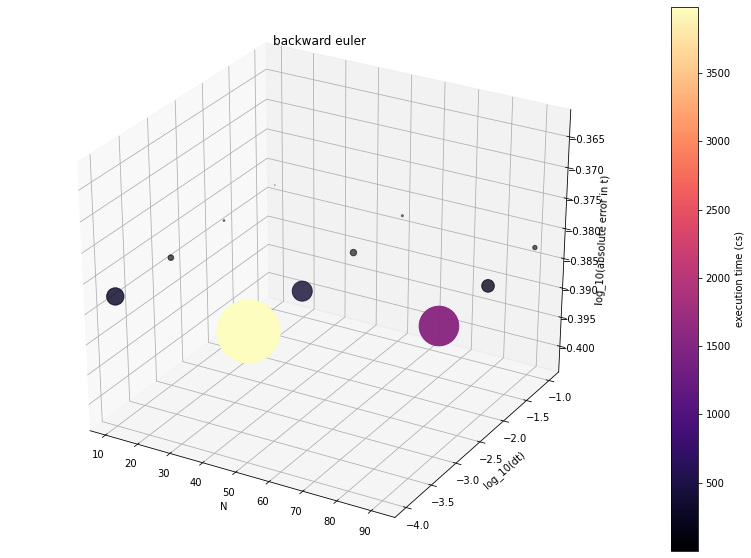

In [ ]:
#now plot results
fig = plt.figure(figsize=(14,10))

ax = fig.add_subplot(111, projection='3d')
ax.set_title('backward euler')

extimelist[:] = [l * 100 for l in extimelist]
#terrlist[:] = [1/l  for l in terrlist]
plot = ax.scatter(Nlist, np.log10(dtlist), np.log10(terrlist), c = extimelist, cmap = 'magma', s=(extimelist))

ax.set_xlabel('N')
ax.set_ylabel('log_10(dt)')
ax.set_zlabel('log_10(absolute error in t)')

cbar = fig.colorbar(plot)
cbar.set_label('execution time (cs)')

Here we see that the runtime increases massively with N and shrinking dt. Since my dt is changing logarithmically it makes sense that the runtime seems to also increase logarithmically (increasing in powers of 10). It always returns t=0.5 for dt=0.1 which is actually a worse approximation than for dt=0.1 and low n from `forward_Euler`. Clearly this is an application that would greatly benefit the speedup offered by GPU computing to solve the linear systems of equations!

Since backward Euler is unconditionally stable, the error depends only on dt. We see this as the number of correct digits is generally the same for the same dt values across different N values. 

In [ ]:
#test- how many correct digits can I get within a reasonable time?
N = 5
dt = 1e-5
A, _ = discretise_poisson(N)
I = identity(N*N)
x = np.zeros((N, N))
x[:,0] = 5
t_steps = 0
while x[N//2, N//2] < 1:
  t_steps += dt
  x = forward_euler(x, dt)

print(f"time taken: {t_steps}.")
print(f"correct time to 12 digits: {t_12}.")

time taken: 0.4231500000002824.
correct time to 12 digits: 0.424011387033.


This is only accurate to 2 digits so clearly backwards Euler does not follow my previous assumption that the number of correct digits is given by the negative power 10 of dt does not hold here. It seems like to get many digits correct would require very small dt, but this is too expensive to run here without parallelization.


For both graphs I had to log_10 my data manually and plot like this because 3d plots on matplotlib apparently do not let you do log axes (ax.loglog, ax.semilogy, ax.set_yscale('log') all don't work).

Thank you to Timo & all of the markers for all your work in term 1! Hope you had a good christmas and happy new year:)